In [2]:
%store -r data

In [3]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def oversampling_smote(X,y):
    from imblearn.over_sampling import SMOTE
    oversample = SMOTE()
    X_smote, y_smote = oversample.fit_resample(X, y)
    print("smote", Counter(y_smote))
    return X_smote, y_smote, oversampling_smote.__name__

X = data
X = X.drop('mood', axis =1)
X = X.drop('time', axis =1)
X = X.drop('encoder_output', axis =1)

y = data['mood']

transform = LabelEncoder()
y = transform.fit_transform(y)

X, y, tech_name = oversampling_smote(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

smote Counter({1: 4032, 0: 4032, 2: 4032})


In [3]:
bucket = "iotproj-training"
prefix = "sagemaker"
s3_train_key = "{}/train/recordio-pb-data".format(prefix)

In [5]:
import os
import io
import boto3
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer


vectors = np.array([t.tolist() for t in X_train.values]).astype("float32")
labels = np.array([t.tolist() for t in y_train]).astype("float32")

vectors_test = np.array([t.tolist() for t in X_test.values]).astype("float32")
labels_test = np.array([t.tolist() for t in y_test]).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource("s3").Bucket(bucket).Object(s3_train_key).upload_fileobj(buf)

In [6]:
# Confirm access to s3 bucket
for obj in boto3.resource("s3").Bucket(bucket).objects.all():
    print(obj.key)

sagemaker/train/recordio-pb-data


In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri
role = 'sagemaker_permissions'
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer


def predictor_from_hyperparams(s3_train_data, hyperparams, output_path):
    
    #Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor

    # specify algorithm containers and instantiate an Estimator with given hyperparams
    container = get_image_uri(boto3.Session().region_name, "linear-learner")

    linear = sagemaker.estimator.Estimator(
        container,
        role,
        train_instance_count=1,
        train_instance_type="ml.m4.xlarge",
        output_path=output_path,
        sagemaker_session=sagemaker.Session(),
    )
    linear.set_hyperparameters(**hyperparams)
    # train model
    linear.fit({"train": s3_train_data})
    # deploy a predictor
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    linear_predictor.serializer = csv_serializer
    linear_predictor.deserializer = json_deserializer
    return linear_predictor

In [8]:
# Training a multiclass classifier with softmax loss
linearlearner_hyperparams = {
    "feature_dim": 2,
    "predictor_type": "multiclass_classifier",
    "loss": "softmax_loss",
    "num_classes" : 3,
    "epochs": 20,
}
linearlearner_output_path = "s3://{}/{}/svm/output".format(bucket, prefix)
s3_train_path = os.path.join("s3://", bucket, s3_train_key)
linearlearner_predictor = predictor_from_hyperparams(s3_train_path, linearlearner_hyperparams, linearlearner_output_path)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-12-06 19:27:04 Starting - Starting the training job...
2021-12-06 19:27:27 Starting - Launching requested ML instancesProfilerReport-1638818824: InProgress
......
2021-12-06 19:28:28 Starting - Preparing the instances for training.........
2021-12-06 19:30:08 Downloading - Downloading input data...
2021-12-06 19:30:33 Training - Downloading the training image...
2021-12-06 19:31:08 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/06/2021 19:31:00 INFO 140097345783616] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_sc

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_seri

Accuracy: 0.925


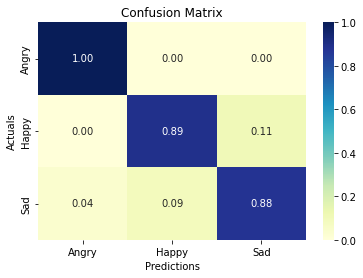

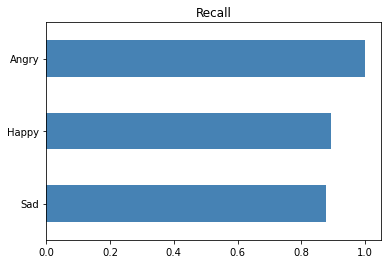

In [44]:
label_map = {0:'Angry', 1:'Happy', 2:'Sad'}

def evaluate_metrics(predictor, test_features, test_labels):
    # Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    
    prediction_batches = [
        predictor.predict(batch)["predictions"]
        for batch in np.array_split(test_features, 100)
    ]
    # parse raw predictions json to exctract predicted label
    test_preds = np.concatenate(
        [np.array([x["predicted_label"] for x in batch]) for batch in prediction_batches]
    )
    test_preds = test_preds.reshape((-1,))
    
    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))
    
# evaluate metrics of the model trained with hyperparameters
evaluate_metrics(linearlearner_predictor, vectors_test, labels_test)